# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
# Check shape, missing data and datatype
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [5]:
# Get null counts
original_missing = azdias.isnull().sum()
original_missing.sum()

4896838

In [6]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Identify missing or unknown data values and convert them to NaNs.
# Strip [] from feat_info.missing_or_unknown
feat_info_clean = feat_info.copy()
feat_info_clean.missing_or_unknown = feat_info.missing_or_unknown.str.strip('[').str.strip(']')

In [8]:
feat_info_clean.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"-1,0"
1,ALTERSKATEGORIE_GROB,person,ordinal,"-1,0,9"
2,ANREDE_KZ,person,categorical,"-1,0"
3,CJT_GESAMTTYP,person,categorical,0
4,FINANZ_MINIMALIST,person,ordinal,-1


In [9]:
# Extract values
feat_info_clean[['first_null', 'second_null', 'third_null']] = feat_info_clean.missing_or_unknown.str.split(',', expand=True)
feat_info_clean.head()

,attribute,information_level,type,missing_or_unknown,first_null,second_null,third_null
0,AGER_TYP,person,categorical,"-1,0",-1,0,None
1,ALTERSKATEGORIE_GROB,person,ordinal,"-1,0,9",-1,0,9
2,ANREDE_KZ,person,categorical,"-1,0",-1,0,None
3,CJT_GESAMTTYP,person,categorical,0,0,None,None
4,FINANZ_MINIMALIST,person,ordinal,-1,-1,None,None


In [10]:
## Create dataframe to assist with replacing 
replace_df = feat_info_clean[['attribute', 'first_null', 'second_null', 'third_null']]
# Transpose for easier comparisons
replace_df = replace_df.set_index('attribute').transpose()
replace_df.head()

attribute,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
first_null,-1,-1,-1,0,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
second_null,0,0,0,None,None,None,None,None,None,None,...,None,None,None,None,0,None,None,9,0,9
third_null,None,9,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [11]:
# Convert as many columns to float as possible
for col in replace_df.columns:
    try:
        replace_df[col] = replace_df[col].astype(float)
    except:
        continue

In [12]:
(replace_df.dtypes == 'float64').sum()

72

In [13]:
(azdias.dtypes == 'float64').sum()

49

In [14]:
replace_df.transpose()[replace_df.dtypes != float]

,first_null,second_null,third_null
attribute,,,
GFK_URLAUBERTYP,,None,None
GREEN_AVANTGARDE,,None,None
ANZ_PERSONEN,,None,None
ANZ_TITEL,,None,None
ANZ_HH_TITEL,,None,None
KONSUMNAEHE,,None,None
CAMEO_DEUG_2015,-1,X,None
CAMEO_DEU_2015,XX,None,None
CAMEO_INTL_2015,-1,XX,None


In [15]:
replace_dict = replace_df.to_dict(orient='list')

In [16]:
# Create copy to retain original data
azdias_clean = azdias.copy()

In [17]:
# Convert to float wherever possible
for col in azdias_clean.columns:
    try:
        azdias_clean[col] = azdias_clean[col].astype(float)
    except:
        continue

In [18]:
# Implement replacement
azdias_clean.replace(replace_dict, np.nan, inplace=True)

In [19]:
# Collect count of missing values in each column
replaced = azdias_clean.isnull().sum()
replaced.sum() # Total missing values

8373929

In [20]:
(replaced - original_missing).sum()

3477091

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [21]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
replaced

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [22]:
# Investigate patterns in the amount of missing data in each column.
replaced.describe()

count        85.000000
mean      98516.811765
std      146604.203317
min           0.000000
25%           0.000000
50%       93148.000000
75%      116515.000000
max      889061.000000
dtype: float64

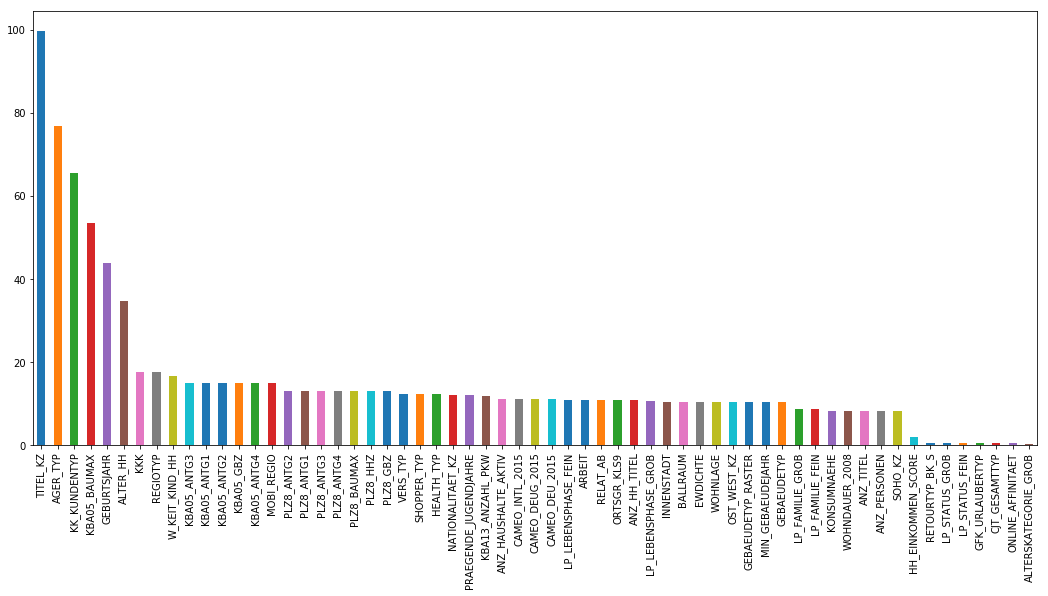

In [27]:
# Investigate patterns in the amount of missing data in each column.
azdias_nan.percent.plot.bar(figsize=(18, 8))

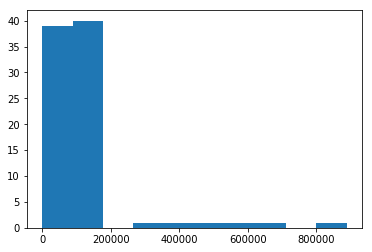

In [23]:
replaced.hist(grid=False)

In [24]:
# Remove the outlier columns from the dataset
high_missing = replaced[replaced > 200000].index
azdias_clean.drop(high_missing, axis=1, inplace=True)
azdias_clean.shape

(891221, 79)

In [25]:
high_missing

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')

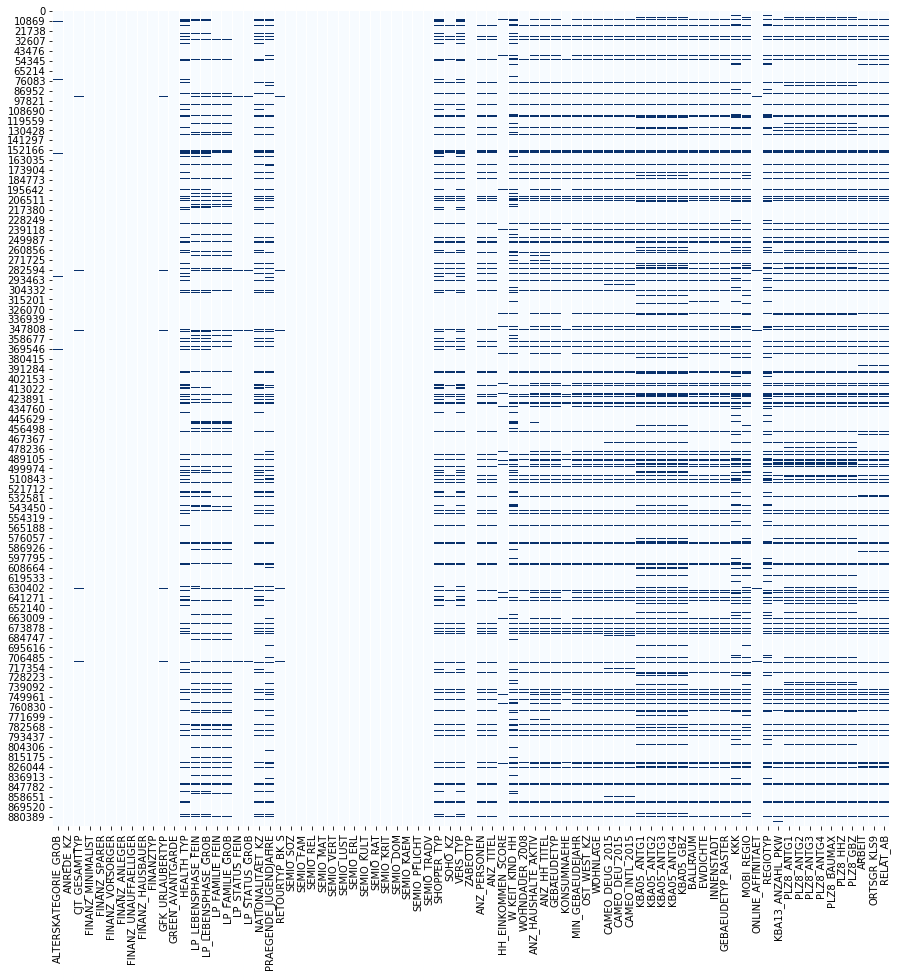

In [26]:
plt.figure(figsize=(15,15))
sns.heatmap(azdias_clean.isnull(), cmap='Blues', cbar=False); # Missing values are dark blue

In [27]:
feat_info_clean.iloc[14:23]

,attribute,information_level,type,missing_or_unknown,first_null,second_null,third_null
14,HEALTH_TYP,person,ordinal,"-1,0",-1,0,None
15,LP_LEBENSPHASE_FEIN,person,mixed,0,0,None,None
16,LP_LEBENSPHASE_GROB,person,mixed,0,0,None,None
17,LP_FAMILIE_FEIN,person,categorical,0,0,None,None
18,LP_FAMILIE_GROB,person,categorical,0,0,None,None
19,LP_STATUS_FEIN,person,categorical,0,0,None,None
20,LP_STATUS_GROB,person,categorical,0,0,None,None
21,NATIONALITAET_KZ,person,categorical,"-1,0",-1,0,None
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"-1,0",-1,0,None


In [28]:
# Determine the index of the first column in the second half that has regular missing data
feat_info_clean.query('attribute == "SHOPPER_TYP"')

,attribute,information_level,type,missing_or_unknown,first_null,second_null,third_null
38,SHOPPER_TYP,person,categorical,-1,-1,None,None


In [29]:
feat_info_clean.iloc[38:]

,attribute,information_level,type,missing_or_unknown,first_null,second_null,third_null
38,SHOPPER_TYP,person,categorical,-1,-1,None,None
39,SOHO_KZ,person,categorical,-1,-1,None,None
40,TITEL_KZ,person,categorical,"-1,0",-1,0,None
41,VERS_TYP,person,categorical,-1,-1,None,None
42,ZABEOTYP,person,categorical,"-1,9",-1,9,None
43,ALTER_HH,household,interval,0,0,None,None
44,ANZ_PERSONEN,household,numeric,,,None,None
45,ANZ_TITEL,household,numeric,,,None,None
46,HH_EINKOMMEN_SCORE,household,ordinal,"-1,0",-1,0,None
47,KK_KUNDENTYP,household,categorical,-1,-1,None,None


#### Discussion 1.1.2: Assess Missing Data in Each Column

The average count for missing values for each column is 76,812, which is less than 10% of the data. However, the maximum number of missing values for a single column ranged all the way up to 685,843, which is more than 75% of the entire dataset.

A plot of the distribution of missing data indicated that there were a few columns that had much higher numbers of missing values. These were AGER_TYP, GEBURTSJAHR, and KK_KUNDENTYP. These values were dropped from the dataset.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [30]:
# How much data is missing in each row of the dataset?
missing_rows = azdias_clean.isnull()
missing_rows.sum(axis=1)

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

In [31]:
missing_row_totals = missing_rows.sum(axis=1)
missing_row_totals.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

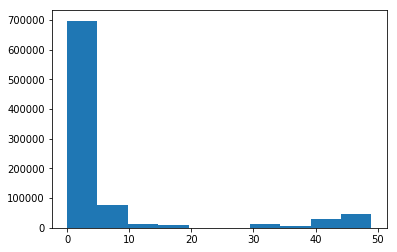

In [32]:
missing_row_totals.hist(grid=False)

In [33]:
# Create column to encode complete and incomplete columns
azdias_clean['complete'] = azdias_clean.isnull().sum(axis=1) == 0
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,complete
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,True
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,True
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,False
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,True


In [34]:
# Count of rows with no missing data
azdias_clean.complete.sum()

623209

In [35]:
# % of rows with no missing data
azdias_clean.complete.sum()/azdias_clean.shape[0]

0.69927548834688591

In [36]:
# Collect columns with limited missing values
low_missing_columns = replaced[replaced < 5].index # replaced previous collected missing counts per column
print('# Columns with low missing values:', len(low_missing_columns))

# Columns with low missing values: 24


In [37]:
sample_columns = np.random.choice(low_missing_columns, 5)
sample_columns

array(['SEMIO_KULT', 'FINANZ_HAUSBAUER', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_PFLICHT'], dtype=object)

In [38]:
# Add 'complete' to column list
sample_columns_list = list(sample_columns)
sample_columns_list.append('complete')
azdias_clean[sample_columns_list].head()

,SEMIO_KULT,FINANZ_HAUSBAUER,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_PFLICHT,complete
0,3.0,3.0,6.0,5.0,5.0,False
1,3.0,5.0,4.0,7.0,7.0,True
2,3.0,5.0,7.0,3.0,3.0,True
3,4.0,2.0,5.0,4.0,4.0,False
4,6.0,2.0,2.0,4.0,4.0,True


In [39]:
def facet_count(data, selected_col):
    complete = azdias_clean[azdias_clean['complete']]
    incomplete = azdias_clean[~azdias_clean['complete']]
    selected_color = sns.color_palette()[0]
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.countplot(x=selected_col, data=complete, color=selected_color)
    plt.title('Complete')
    plt.xlabel('')
    plt.ylabel('')
    plt.subplot(1, 2, 2)
    sns.countplot(x=selected_col, data=incomplete, color=selected_color)
    plt.title('Incomplete')
    plt.xlabel('')
    plt.ylabel('')
    plt.suptitle(selected_col, y=1.07)
    plt.show()

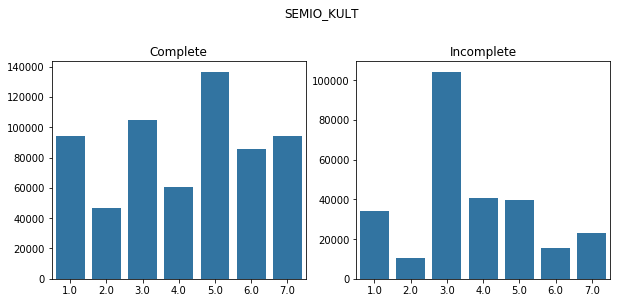

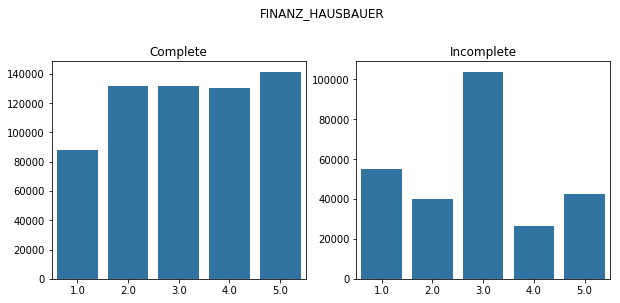

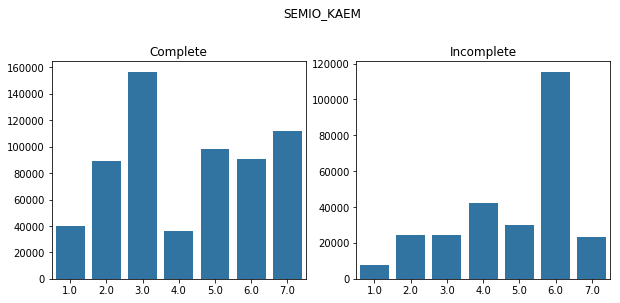

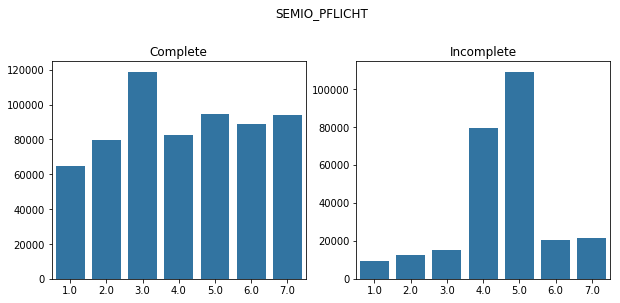

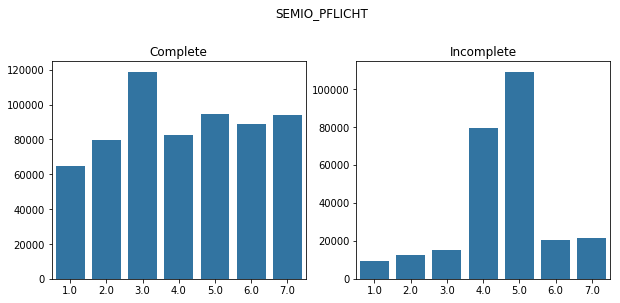

In [40]:
for col in sample_columns:
    facet_count(azdias_clean, col)

#### Discussion 1.1.3: Assess Missing Data in Each Row

There does seem to be a qualitative difference in these demographics when comparing those with large amounts of missing data in other columns and those that do not.

I conducted an examination of the PCA results when retaining all of the missing values, but I found that the segements that were created were more generatlized, and potentially less useful for targetting customers from a banking persepctive. As a result, I decided to drop the missing rows.

This does create a limitation in the analysis in that it excludes certain memebers of the population, but with the additional analysis, I will highlight the key segment that is missing later in the analysis.

In [41]:
# Keep only complete rows
azdias_clean.dropna(inplace=True)

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [42]:
# How many features are there of each data type?
feat_info_clean.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [43]:
# Drop previously dropped columns from feat_info_clean
feat_info_clean = feat_info_clean[~feat_info_clean.attribute.isin(high_missing)]

In [44]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Collect categorical columns
categorical_columns = feat_info_clean.query('type == "categorical"').attribute
print('# Categorical features:', len(categorical_columns))

# Find binary columns
binary_columns = []
for col in categorical_columns:
    value_count = azdias_clean[col].value_counts()
    if len(value_count) ==2:
        binary_columns.append(col)
print('# Binary features:', len(binary_columns))

# Categorical features: 18
# Binary features: 5


In [45]:
binary_columns

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [46]:
for col in binary_columns:
    if azdias_clean[col].dtypes == object:
        print(azdias_clean[col].value_counts())

W    490879
O    132330
Name: OST_WEST_KZ, dtype: int64


In [47]:
recode = {'O': 0, 'W': 1}
azdias_clean.replace({'OST_WEST_KZ': recode}, inplace=True)
# Test
assert(azdias_clean.OST_WEST_KZ.unique().all() in [0, 1])

In [72]:
# Re-encode categorical variable(s) to be kept in the analysis.
for col in categorical_multi:
    print(azdias[col].value_counts())

1.0    191885
2.0    177074
3.0    142655
0.0    111595
Name: SHOPPER_TYP, dtype: int64
1.0    543405
2.0     53856
3.0     25948
Name: NATIONALITAET_KZ, dtype: int64
8    113915
9     87295
6     87089
4     80020
3     63525
7     61735
2     59442
5     41070
1     29118
Name: CAMEO_DEUG_2015, dtype: int64
6B    46538
8A    44209
4C    37949
3C    29054
7A    28310
2D    28132
8B    27905
8C    26729
3D    26633
4A    23899
9B    23231
9D    23196
9C    20625
7B    18432
9A    16677
8D    15072
6E    13823
2C    13582
5D    12285
6C    12060
2B    10828
1D     9485
1A     8789
5B     8071
5C     7432
7C     7156
5A     7018
4D     6981
2A     6900
4B     6855
6A     5352
6D     4943
6F     4373
4E     4336
1E     4093
3B     4031
7D     4008
7E     3829
3A     3807
9E     3566
1C     3440
5F     3437
1B     3311
5E     2827
Name: CAMEO_DEU_2015, dtype: int64
1.0    357714
3.0    140520
8.0    124974
5.0         1
Name: GEBAEUDETYP, dtype: int64
1.0     175564
9.0      97350
10.0    

In [48]:
# Investigate multi-level features
multi_columns = categorical_columns[~categorical_columns.isin(binary_columns)]
multi_columns

3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
42            ZABEOTYP
52         GEBAEUDETYP
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [49]:
for col in multi_columns:
    value_counts = azdias_clean[col].value_counts()
    print('\n')
    print(value_counts)
    print('Total:', value_counts.sum())



4.0    160908
3.0    119004
2.0    113203
5.0     79854
6.0     77273
1.0     72967
Name: CJT_GESAMTTYP, dtype: int64
Total: 623209


6.0    240292
1.0    146234
5.0     88119
2.0     79302
4.0     44630
3.0     24632
Name: FINANZTYP, dtype: int64
Total: 623209


12.0    98076
10.0    81624
8.0     69405
11.0    60164
5.0     57326
4.0     51615
3.0     44233
9.0     41272
1.0     39929
7.0     31423
2.0     27430
6.0     20712
Name: GFK_URLAUBERTYP, dtype: int64
Total: 623209


1.0     325104
10.0    108290
2.0      80801
11.0     41248
8.0      16764
7.0      14077
4.0       9174
5.0       9123
9.0       8831
6.0       6211
3.0       3586
Name: LP_FAMILIE_FEIN, dtype: int64
Total: 623209


1.0    325104
5.0    158369
2.0     80801
4.0     37052
3.0     21883
Name: LP_FAMILIE_GROB, dtype: int64
Total: 623209


1.0     175564
9.0      97350
10.0     93471
2.0      81016
3.0      58334
4.0      58008
6.0      23303
5.0      17870
8.0      10742
7.0       7551
Name: LP_STATUS_FEIN, dty

In a perfect analysis, when deciding to drop these variables I would confirm my assumptions about the relationships between these variables. However, given that we were told it was fine to drop all of them, I am going to make some general assumptions and just keep variables that seem to preserve unique information.

These are the definitions of each of the multi-level categorical variables:

CJT_GESAMTTYP: preferred information and buying channels for consumer (includes details of consumption minimalist and traditionalist, store and online shoppers, and cross-channel types)
FINANZTYP: Most descriptive financial type for individual (includes: low financial interest, money-saver, home ownership, be prepared, investor, inconspicuous)

Investigation of the data dictionary indicates that the variables contained in this feature are actually found their own variables with scales.
GFK_URLAUBERTYP: Vacation habits (includes various types of vacation)

LP_FAMILIE_FEIN: Family type using a fine scale (distinguishes in age, whether partnered, and children age, and generational families)
LP_FAMILIE_GROB: Family type using a broader scale (captures the above categories in broader definitions)
LP_STATUS_FEIN: Social status using a fine scale (distinguishes between low and high income earners as well as some elements of living/work style)
LP_STATUS_GROB: Socail status using a rough scale (captures the above categories in broader definitions)
NATIONALITAET_KZ: Nationality based on given name analysis (includes categories of German-sounding, foreign-sounding, assimilated names)
SHOPPER_TYP: Shopper typology (includes different kinds of shopper habits)
ZABEOTYP: Energy consumption typology (includes categories of consumer decision making approach in considering 'green' alternatives)
GEBAEUDETYP: Type of building - uncertain if this means lived in? (includes different building types)

Investigation of the data dictionary indicates that there is a binary variable that indicates youth participation in an environmental sustainability group.
CAMEO_DEU_2015: Wealth / Life Stage Typology using a fine scale (includes different descriptions of class)

CAMEO_DEUG_2015: Wealth / Life Stage Typology using a broader scale (captures the above categories in broader definitions)
In considering which variables to keep, I decided to keep broader scales over finer scales (as we are trying to reduce dimensionality in pca). I also looked to identify variables that seemed likely to capture the same type of data and only keep one of these.

Financial Status
The variables that appeared to best fall into this category include:

LP_STATUS_FEIN
LP_STATUS_GROB
CAMEO_DEU_2015
CAMEO_DEUG_2015
FINANZTYP
Because financial information is already captured in other variables, these can all be dropped.

Shopper/Consumer Type
The variables that appeared to best fall into this category include:

CJT_GESAMTTYP
SHOPPER_TYP
ZABEOTYP
ZABEOTYP(green consumer type) can be dropped because it has a similar enough capturing in another binary variable. I decided to include CJT_GESAMTTYP (for marketing/shopping behaviour) and for different types of clustering. I decided not to include SHOPPER_TYP because it seemed too similar to CJT_GESAMTTYP.

Family Status
In line with my above reasoning, I decided to keep LP_FAMILIE_GROB over LP_FAMILIE_FEIN

Other Clusters
I also decided to keep GFK_URLAUBERTYP, and NATIONALITAET_KZ, as other potential 'type' clustering mechanisms. I decided to exclude GEBAEUDETYP because I didn't really understand how to interpret/apply it.

As a result the columns to keep are:

CJT_GESAMTTYP
LP_FAMILIE_GROB
GFK_URLAUBERTYP
NATIONALITAET_KZ

In [50]:
# Drop excluded columns
drop_columns = ['LP_STATUS_FEIN', 'LP_STATUS_GROB', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'FINANZTYP',  
                'SHOPPER_TYP', 'ZABEOTYP', 'LP_FAMILIE_FEIN', 'GEBAEUDETYP']
azdias_clean.drop(drop_columns, axis=1, inplace=True)

In [51]:
## Re-encode categorical variable(s) to be kept in the analysis.
# Define categorical columns
cat_keep_columns = ['CJT_GESAMTTYP', 'LP_FAMILIE_GROB', 
                    'GFK_URLAUBERTYP', 'NATIONALITAET_KZ']

# Create df for cat and non-cat columns
azdias_cat = azdias_clean[cat_keep_columns]
azdias_non_cat = azdias_clean.drop(cat_keep_columns, axis=1)

# Implement one-hot encoding
enc = OneHotEncoder(handle_unknown='ignore')
azdias_encode_cat = enc.fit_transform(azdias_cat).toarray()

In [52]:
# Create column list for categories 
cat_cols = ['CJT_GESAMTTYP_1', 'CJT_GESAMTTYP_2', 'CJT_GESAMTTYP_3', 
            'CJT_GESAMTTYP_4', 'CJT_GESAMTTYP_5', 'CJT_GESAMTTYP_6', 
            'LP_FAMILIE_GROB_1', 'LP_FAMILIE_GROB_2', 'LP_FAMILIE_GROB_3', 
            'LP_FAMILIE_GROB_4', 'LP_FAMILIE_GROB_5', 'GFK_URLAUBERTYP_1', 
            'GFK_URLAUBERTYP_2', 'GFK_URLAUBERTYP_3', 'GFK_URLAUBERTYP_4', 
            'GFK_URLAUBERTYP_5', 'GFK_URLAUBERTYP_6', 'GFK_URLAUBERTYP_7', 
            'GFK_URLAUBERTYP_8', 'GFK_URLAUBERTYP_9', 'GFK_URLAUBERTYP_10', 
            'GFK_URLAUBERTYP_11', 'GFK_URLAUBERTYP_12', 'NATIONALITAET_KZ_1', 
            'NATIONALITAET_KZ_2', 'NATIONALITAET_KZ_3']

In [54]:
# Join cat back on to df
# https://stackoverflow.com/questions/50414823/how-to-keep-columns-names-after-one-hot-encoding-sklearn
azdias_dummies = azdias_non_cat.join(pd.DataFrame(azdias_encode_cat, azdias_non_cat.index, columns=cat_cols))
azdias_dummies.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GFK_URLAUBERTYP_6,GFK_URLAUBERTYP_7,GFK_URLAUBERTYP_8,GFK_URLAUBERTYP_9,GFK_URLAUBERTYP_10,GFK_URLAUBERTYP_11,GFK_URLAUBERTYP_12,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [55]:
azdias_dummies.shape

(623209, 93)

#### Discussion 1.2.1: Re-Encode Categorical Features

All categorical variables were identified (after previously dropping some columsn due to high levels of missing values). There were 18 with five that were binary.

OST_WEST_KZ was identified as a binary variable that was encoded with strings and so this was converted to a binary variable with [0, 1] as it's classes.

The remaining categorical variables were inspected for their ability to contribute to determining latent features. Features were dropped if they contained information mostly captured in other variables or if they were encoding data with fine detail when a rough detail alternative was available.

As a result, the following categorical variables were retained:

CJT_GESAMTTYP
LP_FAMILIE_GROB
GFK_URLAUBERTYP
NATIONALITAET_KZ

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [56]:
## "PRAEGENDE_JUGENDJAHRE": engineer two new variables.
# https://chrisalbon.com/python/data_wrangling/pandas_create_column_using_conditional/
# Code MAINSTREAM_AVANTGARDE
mainstream_values = [1, 3, 5, 8, 10, 12, 14]
azdias_dummies['MAINSTREAM_AVANTGARDE'] = np.where(
    azdias_dummies.PRAEGENDE_JUGENDJAHRE.isin(mainstream_values), 0, 1)

# Code DECADE
decade_replace = {'1.0': 1940, '2.0': 1940, '3.0': 1950, '4.0': 1950, '5.0': 1960, 
                  '6.0': 1960, '7.0': 1960, '8.0': 1970, '9.0': 1970, '10.0': 1980, 
                  '11.0': 1980, '12.0': 1980, '13.0': 1980, '14.0': 1990, '15.0': 1990}

azdias_dummies.PRAEGENDE_JUGENDJAHRE = azdias_dummies.PRAEGENDE_JUGENDJAHRE.astype(str)
azdias_dummies.replace({'PRAEGENDE_JUGENDJAHRE': decade_replace}, inplace=True)
azdias_dummies.rename(columns={'PRAEGENDE_JUGENDJAHRE': 'DECADE'}, inplace=True)

In [57]:
# Test
assert('DECADE' in azdias_dummies.columns)
assert('MAINSTREAM_AVANTGARDE' in azdias_dummies.columns)
print(azdias_dummies.DECADE.value_counts())
print(azdias_dummies.MAINSTREAM_AVANTGARDE.value_counts())

1990    178212
1970    143778
1980    121578
1960     95745
1950     62474
1940     21422
Name: DECADE, dtype: int64
0    476988
1    146221
Name: MAINSTREAM_AVANTGARDE, dtype: int64


In [58]:
## "CAMEO_INTL_2015": engineer two new variables.
# Create WEALTH
azdias_dummies['WEALTH'] = azdias_dummies.CAMEO_INTL_2015.astype(str).str[0].astype(int)
# Convert WEALTH so that low value corresponds to low wealth 
azdias_dummies['WEALTH'] = azdias_dummies['WEALTH'] - 5
azdias_dummies['WEALTH'] = azdias_dummies['WEALTH'].abs()
# Create FAMILY_TYP
azdias_dummies['FAMILY_TYP'] = azdias_dummies.CAMEO_INTL_2015.astype(str).str[1].astype(int)
# Drop CAMEO_INTL_2015
azdias_dummies.drop('CAMEO_INTL_2015', axis=1, inplace=True)

In [59]:
# Test
assert('WEALTH' in azdias_dummies.columns)
assert('FAMILY_TYP' in azdias_dummies.columns)
assert('CAMEO_INTL_2015' not in azdias_dummies.columns)
print(azdias_dummies.WEALTH.value_counts())
print(azdias_dummies.FAMILY_TYP.value_counts())

0    184469
1    155270
3    143545
4     88560
2     51365
Name: WEALTH, dtype: int64
1    198278
4    187514
5     93590
3     88280
2     55547
Name: FAMILY_TYP, dtype: int64


In [60]:
feat_info_clean.query('type == "mixed"')

,attribute,information_level,type,missing_or_unknown,first_null,second_null,third_null
15,LP_LEBENSPHASE_FEIN,person,mixed,0,0,None,None
16,LP_LEBENSPHASE_GROB,person,mixed,0,0,None,None
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"-1,0",-1,0,None
56,WOHNLAGE,building,mixed,-1,-1,None,None
59,CAMEO_INTL_2015,microcell_rr4,mixed,"-1,XX",-1,XX,None
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"-1,0",-1,0,None


In [61]:
azdias_dummies.WOHNLAGE.value_counts()

3.0    204534
7.0    132068
4.0    109059
2.0     79948
5.0     56113
1.0     36612
8.0      4871
0.0         4
Name: WOHNLAGE, dtype: int64

In [62]:
# Replace two rural indicators, and 'not calculated' as nan
azdias_dummies.WOHNLAGE.replace([7.0, 8.0, 0.0], np.nan, inplace=True)
#Test
assert(azdias_dummies.WOHNLAGE.isin([7.0, 8.0, 0.0]).sum() == 0)
# Convert WOHNLAGE so that low value corresponds to low wealth 
azdias_dummies['WOHNLAGE'] = azdias_dummies['WOHNLAGE'] - 5
azdias_dummies['WOHNLAGE'] = azdias_dummies['WOHNLAGE'].abs()

In [63]:
azdias_dummies.WOHNLAGE.value_counts()

2.0    204534
1.0    109059
3.0     79948
0.0     56113
4.0     36612
Name: WOHNLAGE, dtype: int64

In [64]:
# Test
assert(azdias_dummies.WOHNLAGE.isna().sum() == 132068 + 4871 + 4)

In [65]:
# Drop unneeded columns
azdias_dummies.drop(['PLZ8_BAUMAX', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

Two of the mixed-type features could be easily engineered: PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015.

For PRAEGENDE_JUGENDJAHRE the data was separated into two features: DECADE and MAINSTREAM_AVANTGARDE. DECADE contains the decade of birth, ranging from 1940 to 1990. MAINSTREAM_AVANTGARDE describes the movement they are associated with, 0 for mainstream, and 1 for avantgarde.

For CAMEO_INTL_2015 the data was also separated into two features: WEALTH and FAMILY_TYP. WEALTH is an interval scale that ranges from Poorer (0) to Wealth (4). FAMILY_TYP is also an interval scale that ranges from Pre-Family Couples and Singles (1) to Elders in Retirement (5), capturing the 'life stage' of the individual.

The remaining mixed-type features were LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, WOHNLAGE and PLZ8_BAUMAX.

LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB both provide age financial information, but these have been captured elsewhere, so they were dropped. PLZ8_BAUMAX provides details of the type of city that an individual lives in by describing the types of buildings found in a key postal code. However, this information is captured in greater detail in a number of interval/ordinal features, so it's information is somewhat redundant and it was dropped.

WOHNLAGE appeared to capture unique information about the wealth of the neighborhood an individual resided in. It was mixed because the final two levels captured residence in a rural area. Because living in a rural area is captured in BALLRAUM (distance to nearest urban centre), these levels were converted to nan's and the remaining levels were retained. This introduced 136,943 nan values into the column.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [66]:
feat_info_clean.query('type == "ordinal"').shape[0]

49

In [67]:
feat_info_clean.query('type == "ordinal"').attribute

1      ALTERSKATEGORIE_GROB
4         FINANZ_MINIMALIST
5             FINANZ_SPARER
6          FINANZ_VORSORGER
7            FINANZ_ANLEGER
8     FINANZ_UNAUFFAELLIGER
9          FINANZ_HAUSBAUER
14               HEALTH_TYP
23           RETOURTYP_BK_S
24                SEMIO_SOZ
25                SEMIO_FAM
26                SEMIO_REL
27                SEMIO_MAT
28               SEMIO_VERT
29               SEMIO_LUST
30                SEMIO_ERL
31               SEMIO_KULT
32                SEMIO_RAT
33               SEMIO_KRIT
34                SEMIO_DOM
35               SEMIO_KAEM
36            SEMIO_PFLICHT
37              SEMIO_TRADV
46       HH_EINKOMMEN_SCORE
48           W_KEIT_KIND_HH
49           WOHNDAUER_2008
53              KONSUMNAEHE
60              KBA05_ANTG1
61              KBA05_ANTG2
62              KBA05_ANTG3
63              KBA05_ANTG4
65                KBA05_GBZ
66                 BALLRAUM
67                 EWDICHTE
68               INNENSTADT
69       GEBAEUDETYP

In [68]:
# Capture reverse-coded columns
reverse_coded = ['FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 
                 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 
                 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 
                 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 
                 'SEMIO_TRADV', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'KKK', 'MOBI_REGIO', 'REGIOTYP']

# Check range for each (i.e. is the full range of values captured?)
azdias_dummies[reverse_coded].max() - azdias_dummies[reverse_coded].min()

FINANZ_MINIMALIST        4.0
FINANZ_SPARER            4.0
FINANZ_VORSORGER         4.0
FINANZ_ANLEGER           4.0
FINANZ_UNAUFFAELLIGER    4.0
FINANZ_HAUSBAUER         4.0
RETOURTYP_BK_S           4.0
SEMIO_SOZ                6.0
SEMIO_FAM                6.0
SEMIO_REL                6.0
SEMIO_MAT                6.0
SEMIO_VERT               6.0
SEMIO_LUST               6.0
SEMIO_ERL                6.0
SEMIO_KULT               6.0
SEMIO_RAT                6.0
SEMIO_KRIT               6.0
SEMIO_DOM                6.0
SEMIO_KAEM               6.0
SEMIO_PFLICHT            6.0
SEMIO_TRADV              6.0
HH_EINKOMMEN_SCORE       5.0
W_KEIT_KIND_HH           5.0
KKK                      3.0
MOBI_REGIO               5.0
REGIOTYP                 6.0
dtype: float64

In [69]:
azdias_consistent_code = azdias_dummies.copy()
azdias_consistent_code[reverse_coded] = azdias_consistent_code[reverse_coded] - azdias_consistent_code[reverse_coded].max()
azdias_consistent_code[reverse_coded] = azdias_consistent_code[reverse_coded].abs()

In [70]:
azdias_dummies[reverse_coded].head()

,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,...,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,KKK,MOBI_REGIO,REGIOTYP
1,1.0,5.0,2.0,5.0,4.0,5.0,1.0,5.0,4.0,4.0,...,4.0,7.0,4.0,7.0,6.0,6.0,3.0,2.0,1.0,3.0
2,1.0,4.0,1.0,2.0,3.0,5.0,3.0,4.0,1.0,3.0,...,7.0,7.0,7.0,3.0,3.0,4.0,3.0,2.0,3.0,2.0
4,4.0,3.0,4.0,1.0,3.0,2.0,5.0,6.0,4.0,4.0,...,3.0,2.0,2.0,4.0,2.0,5.0,2.0,3.0,3.0,5.0
5,3.0,1.0,5.0,2.0,2.0,5.0,3.0,2.0,4.0,7.0,...,4.0,4.0,4.0,7.0,6.0,5.0,6.0,4.0,4.0,5.0
6,1.0,5.0,1.0,5.0,4.0,3.0,4.0,2.0,5.0,5.0,...,7.0,4.0,7.0,7.0,7.0,6.0,3.0,3.0,5.0,5.0


In [71]:
azdias_consistent_code[reverse_coded].head()

,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,...,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,KKK,MOBI_REGIO,REGIOTYP
1,4.0,0.0,3.0,0.0,1.0,0.0,4.0,2.0,3.0,3.0,...,3.0,0.0,3.0,0.0,1.0,0.0,3.0,2.0,5.0,4.0
2,4.0,1.0,4.0,3.0,2.0,0.0,2.0,3.0,6.0,4.0,...,0.0,0.0,0.0,4.0,4.0,2.0,3.0,2.0,3.0,5.0
4,1.0,2.0,1.0,4.0,2.0,3.0,0.0,1.0,3.0,3.0,...,4.0,5.0,5.0,3.0,5.0,1.0,4.0,1.0,3.0,2.0
5,2.0,4.0,0.0,3.0,3.0,0.0,2.0,5.0,3.0,0.0,...,3.0,3.0,3.0,0.0,1.0,1.0,0.0,0.0,2.0,2.0
6,4.0,0.0,4.0,0.0,1.0,2.0,1.0,5.0,2.0,2.0,...,0.0,3.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,2.0


In [72]:
feat_info_clean.query('type == "numeric"').shape[0]

6

In [73]:
feat_info_clean.query('type == "numeric"')

,attribute,information_level,type,missing_or_unknown,first_null,second_null,third_null
44,ANZ_PERSONEN,household,numeric,,,None,None
45,ANZ_TITEL,household,numeric,,,None,None
50,ANZ_HAUSHALTE_AKTIV,building,numeric,0,0,None,None
51,ANZ_HH_TITEL,building,numeric,,,None,None
54,MIN_GEBAEUDEJAHR,building,numeric,0,0,None,None
74,KBA13_ANZAHL_PKW,macrocell_plz8,numeric,,,None,None


In [74]:
# Check data for any missing values that are still 0
(azdias_consistent_code.iloc[:, :35] == 0).sum() # First half

ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
FINANZ_MINIMALIST        124109
FINANZ_SPARER            106218
FINANZ_VORSORGER         189371
FINANZ_ANLEGER           106939
FINANZ_UNAUFFAELLIGER     79909
FINANZ_HAUSBAUER         141398
GREEN_AVANTGARDE         476988
HEALTH_TYP                    0
DECADE                        0
RETOURTYP_BK_S           216856
SEMIO_SOZ                 94251
SEMIO_FAM                 94251
SEMIO_REL                 92565
SEMIO_MAT                 88128
SEMIO_VERT                84980
SEMIO_LUST               116216
SEMIO_ERL                126089
SEMIO_KULT                94251
SEMIO_RAT                 72829
SEMIO_KRIT                94024
SEMIO_DOM                142154
SEMIO_KAEM               112062
SEMIO_PFLICHT             93851
SEMIO_TRADV               61256
SOHO_KZ                  617913
VERS_TYP                      0
ANZ_PERSONEN                  0
ANZ_TITEL                620782
HH_EINKOMMEN_SCORE       210869
W_KEIT_K

In [75]:
(azdias_consistent_code.iloc[:, 35:] == 0).sum() # Second half

KONSUMNAEHE                   0
MIN_GEBAEUDEJAHR              0
OST_WEST_KZ              132330
WOHNLAGE                  56113
KBA05_ANTG1              215564
KBA05_ANTG2              238231
KBA05_ANTG3              419177
KBA05_ANTG4              496109
KBA05_GBZ                     0
BALLRAUM                      0
EWDICHTE                      0
INNENSTADT                    0
GEBAEUDETYP_RASTER            0
KKK                      152567
MOBI_REGIO                  159
ONLINE_AFFINITAET         49975
REGIOTYP                  70056
KBA13_ANZAHL_PKW              0
PLZ8_ANTG1                 4836
PLZ8_ANTG2                 6151
PLZ8_ANTG3                90283
PLZ8_ANTG4               279232
PLZ8_HHZ                      0
PLZ8_GBZ                      0
ARBEIT                        0
ORTSGR_KLS9                   0
RELAT_AB                      0
complete                      0
CJT_GESAMTTYP_1          550242
CJT_GESAMTTYP_2          510006
CJT_GESAMTTYP_3          504205
CJT_GESA

In [76]:
# Check data for any missing values that are still -1
(azdias_consistent_code == -1).sum().sum()

0

In [77]:
# Check if any columns are still str
(azdias_consistent_code.dtypes == object).sum()

0

In [78]:
azdias_consistent_code.shape

(623209, 92)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [79]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: 
        data_df: Demographics DataFrame
        feature_replace: dict containing replacement values
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Convert NaNs coded values
    replace_dict = {'AGER_TYP': [-1.0, 0.0],
                    'ALTERSKATEGORIE_GROB': [-1.0, 0.0, 9.0],
                    'ANREDE_KZ': [-1.0, 0.0],
                    'CJT_GESAMTTYP': [0.0],
                    'FINANZ_MINIMALIST': [-1.0],
                    'FINANZ_SPARER': [-1.0],
                    'FINANZ_VORSORGER': [-1.0],
                    'FINANZ_ANLEGER': [-1.0],
                    'FINANZ_UNAUFFAELLIGER': [-1.0],
                    'FINANZ_HAUSBAUER': [-1.0],
                    'FINANZTYP': [-1.0],
                    'GEBURTSJAHR': [0.0],
                    'HEALTH_TYP': [-1.0, 0.0],
                    'LP_LEBENSPHASE_FEIN': [0.0],
                    'LP_LEBENSPHASE_GROB': [0.0],
                    'LP_FAMILIE_FEIN': [0.0],
                    'LP_FAMILIE_GROB': [0.0],
                    'LP_STATUS_FEIN': [0.0],
                    'LP_STATUS_GROB': [0.0],
                    'NATIONALITAET_KZ': [-1.0, 0.0],
                    'PRAEGENDE_JUGENDJAHRE': [-1.0, 0.0],
                    'RETOURTYP_BK_S': [0.0],
                    'SEMIO_SOZ': [-1.0, 9.0],
                    'SEMIO_FAM': [-1.0, 9.0],
                    'SEMIO_REL': [-1.0, 9.0],
                    'SEMIO_MAT': [-1.0, 9.0],
                    'SEMIO_VERT': [-1.0, 9.0],
                    'SEMIO_LUST': [-1.0, 9.0],
                    'SEMIO_ERL': [-1.0, 9.0],
                    'SEMIO_KULT': [-1.0, 9.0],
                    'SEMIO_RAT': [-1.0, 9.0],
                    'SEMIO_KRIT': [-1.0, 9.0],
                    'SEMIO_DOM': [-1.0, 9.0],
                    'SEMIO_KAEM': [-1.0, 9.0],
                    'SEMIO_PFLICHT': [-1.0, 9.0],
                    'SEMIO_TRADV': [-1.0, 9.0],
                    'SHOPPER_TYP': [-1.0],
                    'SOHO_KZ': [-1.0],
                    'TITEL_KZ': [-1.0, 0.0],
                    'VERS_TYP': [-1.0],
                    'ZABEOTYP': [-1.0, 9.0],
                    'ALTER_HH': [0.0],
                    'HH_EINKOMMEN_SCORE': [-1.0, 0.0],
                    'KK_KUNDENTYP': [-1.0],
                    'W_KEIT_KIND_HH': [-1.0, 0.0],
                    'WOHNDAUER_2008': [-1.0, 0.0],
                    'ANZ_HAUSHALTE_AKTIV': [0.0],
                    'GEBAEUDETYP': [-1.0, 0.0],
                    'MIN_GEBAEUDEJAHR': [0.0],
                    'OST_WEST_KZ': [-1.0],
                    'WOHNLAGE': [-1.0],
                    'CAMEO_DEUG_2015': ['-1', 'X'],
                    'CAMEO_DEU_2015': ['XX'],
                    'CAMEO_INTL_2015': ['-1', 'XX'],
                    'KBA05_ANTG1': [-1.0],
                    'KBA05_ANTG2': [-1.0],
                    'KBA05_ANTG3': [-1.0],
                    'KBA05_ANTG4': [-1.0],
                    'KBA05_BAUMAX': [-1.0, 0.0],
                    'KBA05_GBZ': [-1.0, 0.0],
                    'BALLRAUM': [-1.0],
                    'EWDICHTE': [-1.0],
                    'INNENSTADT': [-1.0],
                    'KKK': [-1.0, 0.0],
                    'REGIOTYP': [-1.0, 0.0],
                    'PLZ8_ANTG1': [-1.0],
                    'PLZ8_ANTG2': [-1.0],
                    'PLZ8_ANTG3': [-1.0],
                    'PLZ8_ANTG4': [-1.0],
                    'PLZ8_BAUMAX': [-1.0, 0.0],
                    'PLZ8_HHZ': [-1.0],
                    'PLZ8_GBZ': [-1.0],
                    'ARBEIT': [-1.0, 9.0],
                    'ORTSGR_KLS9': [-1.0, 0.0],
                    'RELAT_AB': [-1.0, 9.0]}
    
    # Convert data_df to float wherever possible
    for col in df.columns:
        try:
            df[col] = df[col].astype(float)
        except:
            continue

    df.replace(replace_dict, np.nan, inplace=True)    
    
    ## Drop columns and rows
    drop_columns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 
                    'KK_KUNDENTYP', 'KBA05_BAUMAX', 'LP_STATUS_FEIN', 
                    'LP_STATUS_GROB', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 
                    'FINANZTYP', 'SHOPPER_TYP', 'ZABEOTYP', 'LP_FAMILIE_FEIN', 
                    'GEBAEUDETYP', 'PLZ8_BAUMAX', 'LP_LEBENSPHASE_FEIN', 
                    'LP_LEBENSPHASE_GROB']
    
    df.drop(drop_columns, axis=1, inplace=True)
    
    df.dropna(inplace=True)
    
    ### Feature engineering
    ## OST_WEST_KZ
    recode = {'O': 0, 'W': 1}
    df.replace({'OST_WEST_KZ': recode}, inplace=True)
    
    ## One-hot encode categorical columns
    cat_columns = ['CJT_GESAMTTYP', 'LP_FAMILIE_GROB', 
                    'GFK_URLAUBERTYP', 'NATIONALITAET_KZ']
    cat_df = df[cat_columns]
    non_cat_df = df.drop(cat_columns, axis=1)
    
    # Implement encoding
    enc = OneHotEncoder(handle_unknown='ignore')
    cat_array = enc.fit_transform(cat_df).toarray()
    
    # Create column list for categories 
    new_cols = ['CJT_GESAMTTYP_1', 'CJT_GESAMTTYP_2', 'CJT_GESAMTTYP_3', 
            'CJT_GESAMTTYP_4', 'CJT_GESAMTTYP_5', 'CJT_GESAMTTYP_6', 
            'LP_FAMILIE_GROB_1', 'LP_FAMILIE_GROB_2', 'LP_FAMILIE_GROB_3', 
            'LP_FAMILIE_GROB_4', 'LP_FAMILIE_GROB_5', 'GFK_URLAUBERTYP_1', 
            'GFK_URLAUBERTYP_2', 'GFK_URLAUBERTYP_3', 'GFK_URLAUBERTYP_4', 
            'GFK_URLAUBERTYP_5', 'GFK_URLAUBERTYP_6', 'GFK_URLAUBERTYP_7', 
            'GFK_URLAUBERTYP_8', 'GFK_URLAUBERTYP_9', 'GFK_URLAUBERTYP_10', 
            'GFK_URLAUBERTYP_11', 'GFK_URLAUBERTYP_12', 'NATIONALITAET_KZ_1', 
            'NATIONALITAET_KZ_2', 'NATIONALITAET_KZ_3']
    
    # Re-create df
    df = non_cat_df.join(pd.DataFrame(
        cat_array, non_cat_df.index, columns=new_cols))
    
    ## PRAEGENDE_JUGENDE
    # MAINSTREAM_AVANTGARDE
    mainstream_values = [1, 3, 5, 8, 10, 12, 14]
    df['MAINSTREAM_AVANTGARDE'] = np.where(
        df['PRAEGENDE_JUGENDJAHRE'].isin(mainstream_values), 0, 1)
    
    # DECADE
    decade_replace = {'1.0': 1940, '2.0': 1940, '3.0': 1950, '4.0': 1950, 
                      '5.0': 1960, '6.0': 1960, '7.0': 1960, '8.0': 1970, 
                      '9.0': 1970, '10.0': 1980, '11.0': 1980, '12.0': 1980, 
                      '13.0': 1980, '14.0': 1990, '15.0': 1990}
    
    df['PRAEGENDE_JUGENDJAHRE'] = df['PRAEGENDE_JUGENDJAHRE'].astype(str)
    
    df.replace({'PRAEGENDE_JUGENDJAHRE': decade_replace}, inplace=True)
    df.rename(columns={'PRAEGENDE_JUGENDJAHRE': 'DECADE'}, inplace=True)
    
    ## CAMEO_INTL_2015
    # WEALTH
    df['WEALTH'] = df['CAMEO_INTL_2015'].astype(str).str[0].astype(int)
    # FAMILY
    df['FAMILY_TYP'] = df['CAMEO_INTL_2015'].astype(str).str[1].astype(int)
    # Drop original
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    ## WOHNLAGE
    df['WOHNLAGE'].replace([7.0, 8.0, 0.0], np.nan, inplace=True)
    
    ## Correct reverse-coded columns
    reverse_coded = ['FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 
                     'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 
                     'FINANZ_HAUSBAUER', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 
                     'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 
                     'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 
                     'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 
                     'SEMIO_TRADV', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 
                     'KKK', 'MOBI_REGIO', 'REGIOTYP', 'WEALTH', 'WOHNLAGE']
    df[reverse_coded] = df[reverse_coded] - df[reverse_coded].max()
    df[reverse_coded] = df[reverse_coded].abs()
    
    # Add 'complete' column to match
    df['complete'] = True
    
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [80]:
# Check rows with missing values due to feature engineering
azdias_consistent_code.isnull().sum().sum()

136943

In [81]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaler.fit(azdias_consistent_code.dropna()) # Drop na for fit
imputer = Imputer()
azdias_imputed = imputer.fit_transform(azdias_consistent_code) # Impute the mean for missing values
azdias_standard = scaler.fit_transform(azdias_imputed) # Finally transform

### Discussion 2.1: Apply Feature Scaling

As mentioned in the section 1.1.3, the strategy of dealing with missing values should be well thought. It means that for every column there could be a different way of dealing with NaNs. This requires domain knowledge, knowledge of existing research or external data sources to get the missing data or develop a computational logic to fill the gaps.

After removing rows with NaNs (step 1), the features were scaled to mean 0 and standard deviation 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [82]:
# Apply PCA to the data.
pca = PCA()
X_pca = pca.fit_transform(azdias_standard)

In [83]:
# Investigate the variance accounted for by each principal component.
pca.explained_variance_ratio_

array([  1.28984561e-01,   1.01944024e-01,   6.87317009e-02,
         4.05413702e-02,   3.08267262e-02,   2.48636635e-02,
         2.27351385e-02,   2.04737734e-02,   2.01319394e-02,
         1.78115337e-02,   1.63163328e-02,   1.52842287e-02,
         1.47825808e-02,   1.44566850e-02,   1.40738352e-02,
         1.37173140e-02,   1.35440072e-02,   1.31458472e-02,
         1.29067922e-02,   1.27246144e-02,   1.24736229e-02,
         1.22803135e-02,   1.21693185e-02,   1.20545405e-02,
         1.19841551e-02,   1.18382162e-02,   1.15024477e-02,
         1.14149545e-02,   1.13267901e-02,   1.12386385e-02,
         1.10456440e-02,   1.09824672e-02,   1.09266103e-02,
         1.08537228e-02,   1.07197571e-02,   9.89806700e-03,
         9.54301182e-03,   9.30783893e-03,   9.04619551e-03,
         8.87043456e-03,   8.60195302e-03,   8.24471014e-03,
         8.06064696e-03,   8.04112106e-03,   7.80489959e-03,
         7.57416509e-03,   6.86363254e-03,   5.98312232e-03,
         5.38726799e-03,

In [84]:
# Implement scree_plot based off Udacity defined function
def scree_plot(pca, annotate=False, limit=None, figsize=(15,9)):
    values = pca.explained_variance_ratio_
    if limit:
        values = values[:limit]
    n_components = len(values)
    ind = np.arange(n_components)
    
    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    cumvalues = np.cumsum(values)
    ax.bar(ind, values)
    ax.plot(ind, cumvalues)
    if annotate:
        for i in range(n_components):
            ax.annotate(r"%s%%" % ((str(values[i]*100)[:4])), 
                        (ind[i]+0.2, values[i]),
                        va="bottom",
                        ha="center",
                        fontsize=10)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    #ax.yaxis.set_ticks(np.arange(0, 120, 20))
    
    ax.set_xlabel("Principal Component", fontsize=14)
    ax.set_ylabel("Variance Explained (%)", fontsize=14)
    if limit:
        plt.title("Explained Variance Per Principle Component for First {} Features".format(limit), fontsize=18);
    else:
        plt.title("Explained Variance Per Principle Component", fontsize=18)

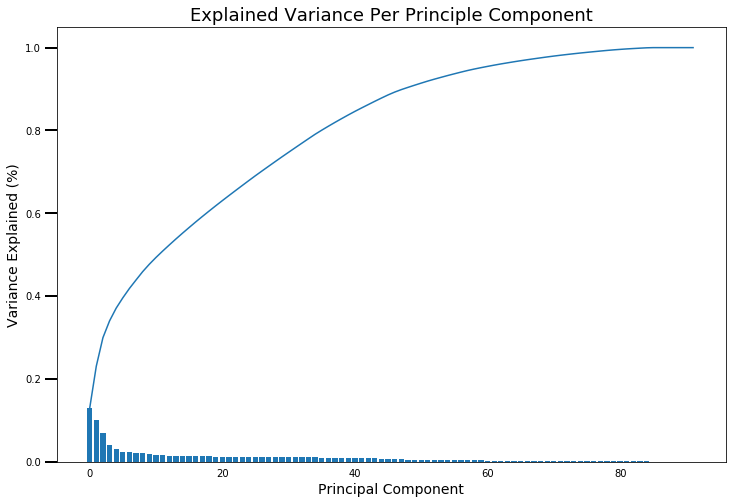

In [85]:
scree_plot(pca, figsize=(12, 8))

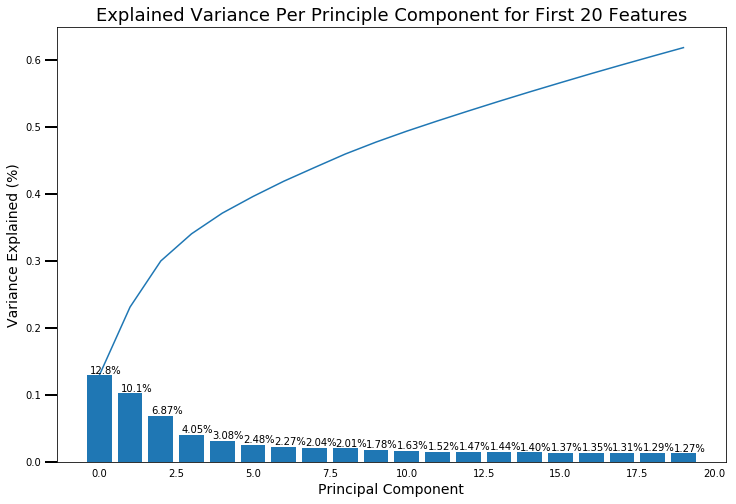

In [87]:
scree_plot(pca, annotate=True, limit=20, figsize=(12, 8))

In [88]:
pca.explained_variance_ratio_[:3].sum()

0.29966028582585025

In [89]:
for i in np.arange(5, 40, 5):
    print('For {} components, explained variance:'.format(i), 
          pca.explained_variance_ratio_[:i].sum())

For 5 components, explained variance: 0.371028382159
For 10 components, explained variance: 0.477044430735
For 15 components, explained variance: 0.551958093171
For 20 components, explained variance: 0.617996668158
For 25 components, explained variance: 0.678958618559
For 30 components, explained variance: 0.736279665629
For 35 components, explained variance: 0.790807867089


In [90]:
pca.explained_variance_ratio_[:25].sum() - pca.explained_variance_ratio_[:20].sum()

0.06096195040069019

In [91]:
pca.explained_variance_ratio_[:20].sum() - pca.explained_variance_ratio_[:15].sum()

0.066038574986907572

In [92]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_20 = PCA(n_components=20)
X_pca_20 = pca_20.fit_transform(azdias_standard)

### Discussion 2.2: Perform Dimensionality Reduction

Discussion 2.2: Perform Dimensionality Reduction
There are a number of potential methods to determine where to cut the number of features. In this case, I was looking to balance a number of considerations. I wanted to be able to explain a reasonable amount of the variance, while not creating too many segments, making it difficult for the bank to develop a comprehensive targeting strategy. I also considered how much each additional component was adding to the cumulative explained variance.

I settled upon 20 components, capturing more than 60% of the variance, with each component only adding an additional approximately 1% variance explained.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [93]:
# Implement collection of results based off Udacity defined function
def pca_results(full_dataset, pca):
    # Create dimensions index
    dimensions = ['Dimension {}'.format(i) for i \
                  in range(1, len(pca.components_) + 1)]
    
    # Capture pca components
    pca_comp = pca.components_
    
    # Create components df
    components_df = pd.DataFrame(np.round(pca_comp, 4), 
                              columns= full_dataset.columns)
    components_df.index = dimensions
    
    # Create PCA variance explained df
    ratios = pca.explained_variance_ratio_.reshape(len(pca_comp), 1)
    ratios_df = pd.DataFrame(np.round(ratios, 4), 
                             columns=['Explained Variance'])
    ratios_df.index = dimensions
    
    # Return combined df
    return pd.merge(ratios_df, components_df, left_index=True, right_index=True)

In [94]:
results = pca_results(azdias_consistent_code, pca_20)
results.head()

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,GFK_URLAUBERTYP_9,GFK_URLAUBERTYP_10,GFK_URLAUBERTYP_11,GFK_URLAUBERTYP_12,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,MAINSTREAM_AVANTGARDE,WEALTH,FAMILY_TYP
Dimension 1,0.1290,-0.1584,-0.0077,0.2196,-0.1753,0.1461,-0.0985,-0.1051,-0.1319,-0.1132,...,0.0158,-0.0059,0.0340,0.0762,-0.0860,0.0714,0.0433,-0.1132,-0.1860,-0.1227
Dimension 2,0.1019,0.2263,0.0741,-0.0252,0.1998,-0.1981,0.1857,0.2037,-0.1396,-0.0412,...,-0.0734,0.0060,-0.0063,-0.0253,0.0571,-0.0372,-0.0432,-0.0412,-0.1062,-0.0263
Dimension 3,0.0687,0.0663,-0.3695,-0.1499,0.0863,-0.0837,0.1750,0.0780,0.0518,0.0491,...,-0.0373,0.0023,-0.0077,-0.0205,0.0087,0.0199,-0.0424,0.0491,-0.0215,-0.0095
Dimension 4,0.0405,-0.0242,0.0372,-0.0537,0.0085,0.0069,0.1213,-0.0624,0.0865,0.3492,...,0.0165,0.0465,-0.0135,-0.1065,-0.0091,0.0129,-0.0030,0.3492,0.0992,0.0523
Dimension 5,0.0308,0.0573,-0.0128,-0.0380,0.0134,-0.0063,-0.0736,0.0913,0.0210,-0.0998,...,0.1270,-0.0082,0.0283,-0.0750,-0.0074,0.0156,-0.0096,-0.0998,-0.0853,-0.0359


In [95]:
# Implement plot of results
def plot_pca_dim(results_df, pca, dimension_name, figsize=(14, 8)):
    # Collect dimension info
    dimension = results_df.loc[dimension_name, 'ALTERSKATEGORIE_GROB':]\
    .sort_values(ascending=False)
    positive = dimension[dimension >=0]
    negative = dimension[dimension <0]
    
    # Create bar plot
    plt.figure(figsize=figsize)
    plt.subplot(211)
    positive.plot(kind='bar')
    plt.axhline(y=0.15, ls='--', c='#b3b3b3', lw=1)
    #plt.grid(axis='y')
    plt.ylabel("Feature Weights")
    plt.subplot(212)
    negative.plot(kind='bar')
    plt.axhline(y=-0.15, ls='--', c='#b3b3b3', lw=1);
    #plt.grid(axis='y')
    plt.ylabel("Feature Weights")
    plt.subplots_adjust(bottom=0.8)
    plt.suptitle("{}: {}% Variance Explained".format(
        dimension_name, 
        np.round(results_df.loc[dimension_name, 'Explained Variance']*100, 2)),
                 fontsize=18)
    plt.tight_layout()

In [96]:
# Implement print-out of higher weighted features
def weighted_features(results, dimension_name):
    print("High Positive\n", 
      results.loc[dimension_name][results.loc[dimension_name] >= 0.15].sort_values(ascending=False))
    print("\nHigh Negative\n", 
      results.loc[dimension_name][results.loc[dimension_name] <= -0.15].sort_values())

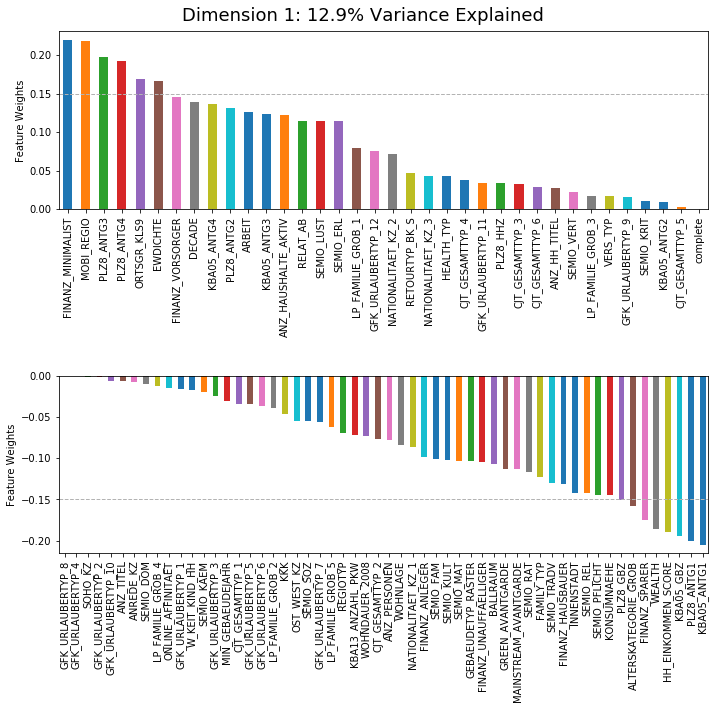

In [97]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_pca_dim(results, pca_20, 'Dimension 1', figsize=(10, 10))

In [98]:
weighted_features(results, 'Dimension 1')

High Positive
 FINANZ_MINIMALIST    0.2196
MOBI_REGIO           0.2188
PLZ8_ANTG3           0.1976
PLZ8_ANTG4           0.1923
ORTSGR_KLS9          0.1692
EWDICHTE             0.1664
Name: Dimension 1, dtype: float64

High Negative
 KBA05_ANTG1            -0.2052
PLZ8_ANTG1             -0.1999
KBA05_GBZ              -0.1940
HH_EINKOMMEN_SCORE     -0.1890
WEALTH                 -0.1860
FINANZ_SPARER          -0.1753
ALTERSKATEGORIE_GROB   -0.1584
PLZ8_GBZ               -0.1503
Name: Dimension 1, dtype: float64


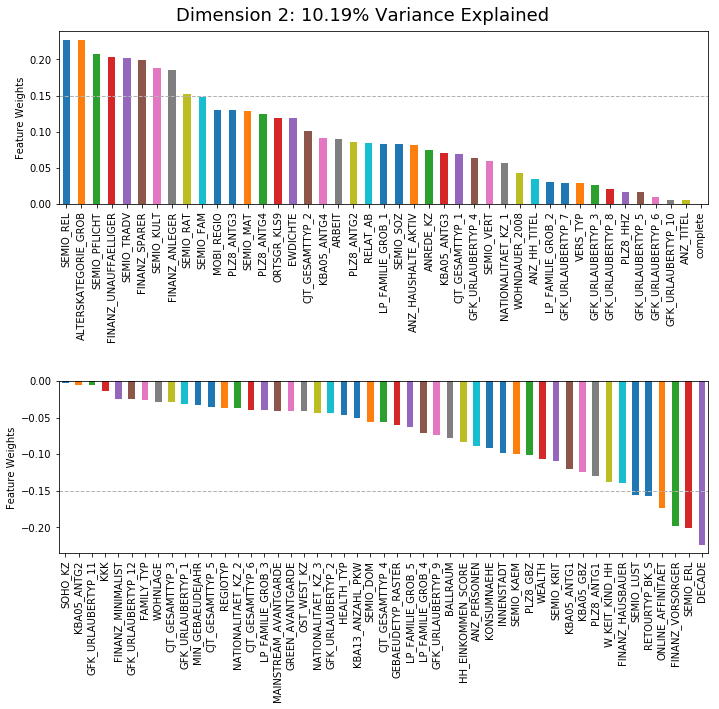

In [99]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_pca_dim(results, pca_20, 'Dimension 2', figsize=(10, 10))

In [100]:
weighted_features(results, 'Dimension 2')

High Positive
 SEMIO_REL                0.2272
ALTERSKATEGORIE_GROB     0.2263
SEMIO_PFLICHT            0.2081
FINANZ_UNAUFFAELLIGER    0.2037
SEMIO_TRADV              0.2018
FINANZ_SPARER            0.1998
SEMIO_KULT               0.1882
FINANZ_ANLEGER           0.1857
SEMIO_RAT                0.1516
Name: Dimension 2, dtype: float64

High Negative
 DECADE              -0.2242
SEMIO_ERL           -0.2004
FINANZ_VORSORGER    -0.1981
ONLINE_AFFINITAET   -0.1736
RETOURTYP_BK_S      -0.1565
SEMIO_LUST          -0.1560
Name: Dimension 2, dtype: float64


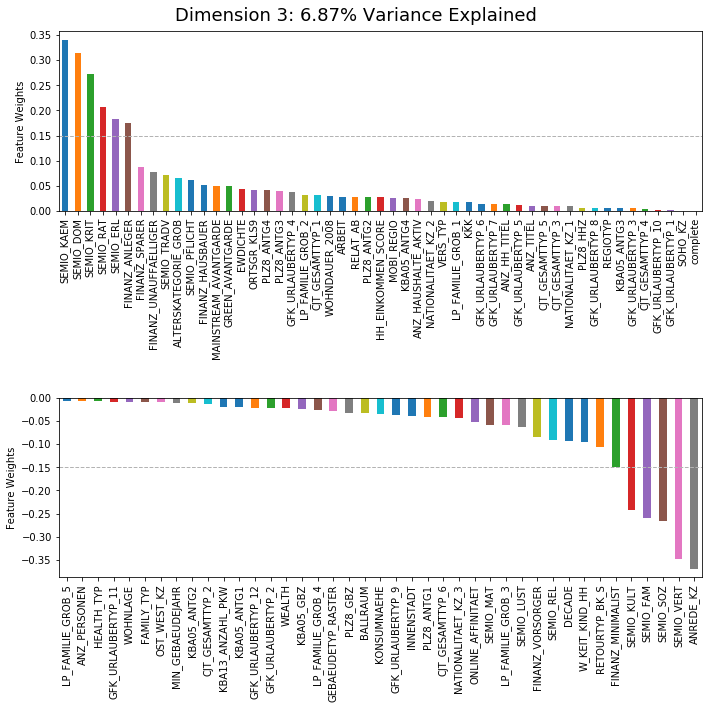

In [101]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_pca_dim(results, pca_20, 'Dimension 3', figsize=(10, 10))

In [102]:
weighted_features(results, 'Dimension 3')

High Positive
 SEMIO_KAEM        0.3404
SEMIO_DOM         0.3139
SEMIO_KRIT        0.2725
SEMIO_RAT         0.2064
SEMIO_ERL         0.1823
FINANZ_ANLEGER    0.1750
Name: Dimension 3, dtype: float64

High Negative
 ANREDE_KZ    -0.3695
SEMIO_VERT   -0.3484
SEMIO_SOZ    -0.2671
SEMIO_FAM    -0.2600
SEMIO_KULT   -0.2424
Name: Dimension 3, dtype: float64


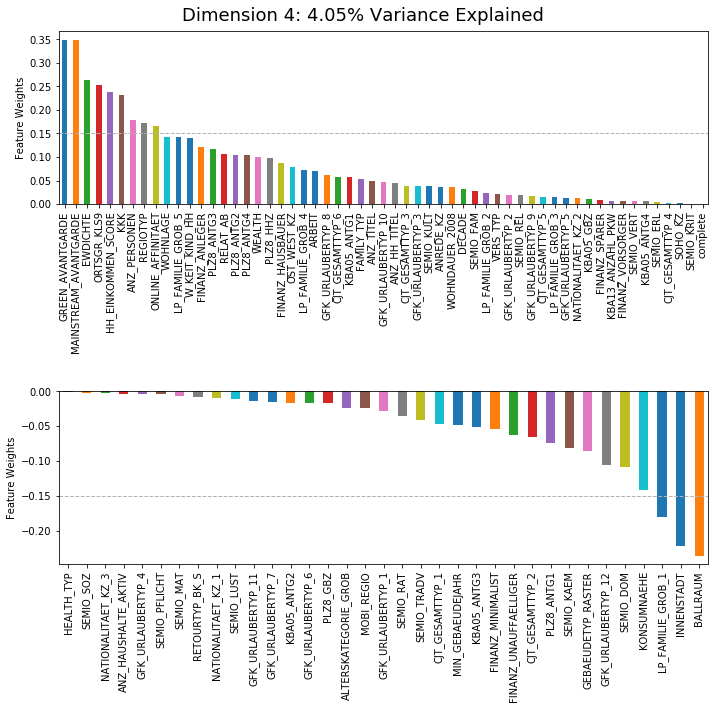

In [103]:
# Looking at the fourth dimension
plot_pca_dim(results, pca_20, 'Dimension 4', figsize=(10, 10))

In [104]:
weighted_features(results, 'Dimension 4')

High Positive
 MAINSTREAM_AVANTGARDE    0.3492
GREEN_AVANTGARDE         0.3492
EWDICHTE                 0.2635
ORTSGR_KLS9              0.2535
HH_EINKOMMEN_SCORE       0.2378
KKK                      0.2323
ANZ_PERSONEN             0.1784
REGIOTYP                 0.1719
ONLINE_AFFINITAET        0.1650
Name: Dimension 4, dtype: float64

High Negative
 BALLRAUM            -0.2361
INNENSTADT          -0.2228
LP_FAMILIE_GROB_1   -0.1801
Name: Dimension 4, dtype: float64


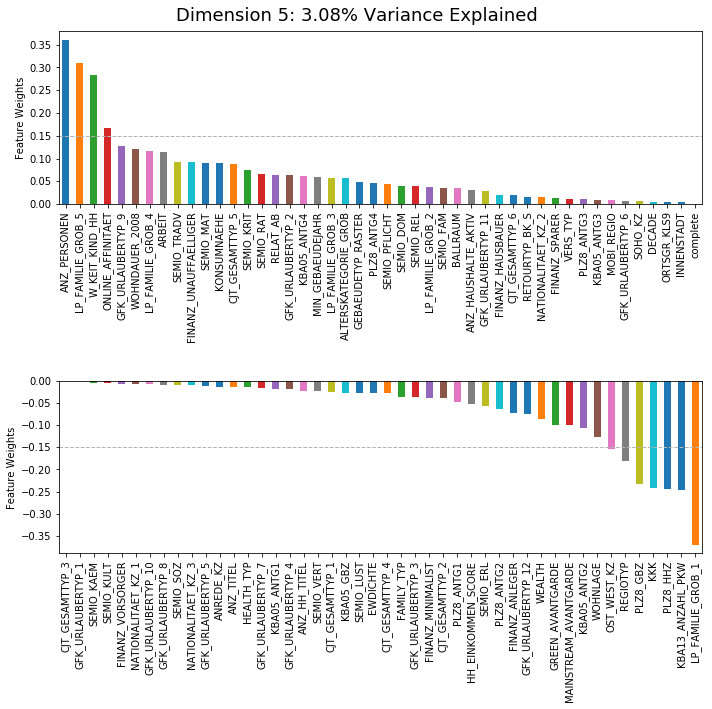

In [105]:
# Looking at the fifth dimension
plot_pca_dim(results, pca_20, 'Dimension 5', figsize=(10, 10))

In [106]:
weighted_features(results, 'Dimension 5')

High Positive
 ANZ_PERSONEN         0.3607
LP_FAMILIE_GROB_5    0.3093
W_KEIT_KIND_HH       0.2836
ONLINE_AFFINITAET    0.1665
Name: Dimension 5, dtype: float64

High Negative
 LP_FAMILIE_GROB_1   -0.3712
KBA13_ANZAHL_PKW    -0.2472
PLZ8_HHZ            -0.2449
KKK                 -0.2412
PLZ8_GBZ            -0.2324
REGIOTYP            -0.1817
OST_WEST_KZ         -0.1544
Name: Dimension 5, dtype: float64


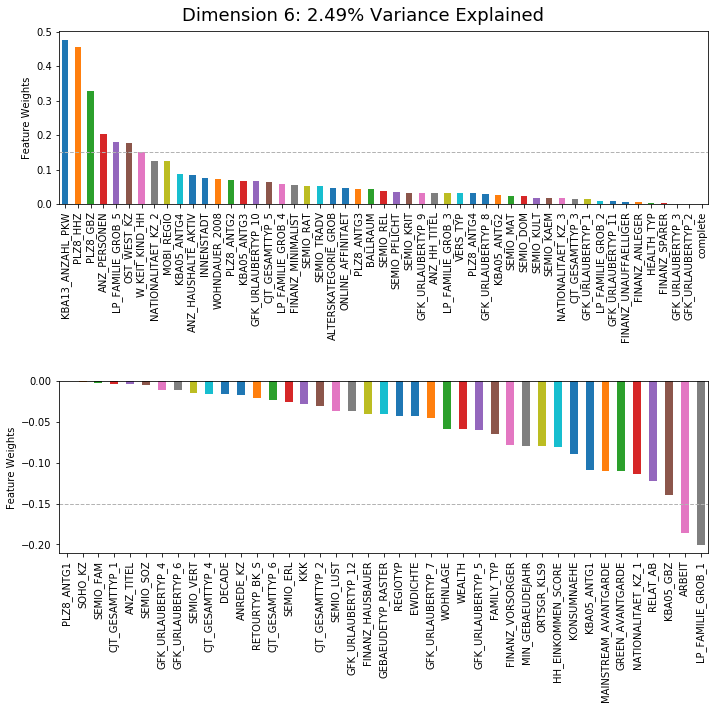

In [107]:
# Looking at the sixth dimension
plot_pca_dim(results, pca_20, 'Dimension 6', figsize=(10, 10))

In [108]:
weighted_features(results, 'Dimension 6')

High Positive
 KBA13_ANZAHL_PKW     0.4769
PLZ8_HHZ             0.4560
PLZ8_GBZ             0.3269
ANZ_PERSONEN         0.2046
LP_FAMILIE_GROB_5    0.1792
OST_WEST_KZ          0.1774
W_KEIT_KIND_HH       0.1501
Name: Dimension 6, dtype: float64

High Negative
 LP_FAMILIE_GROB_1   -0.2009
ARBEIT              -0.1855
Name: Dimension 6, dtype: float64


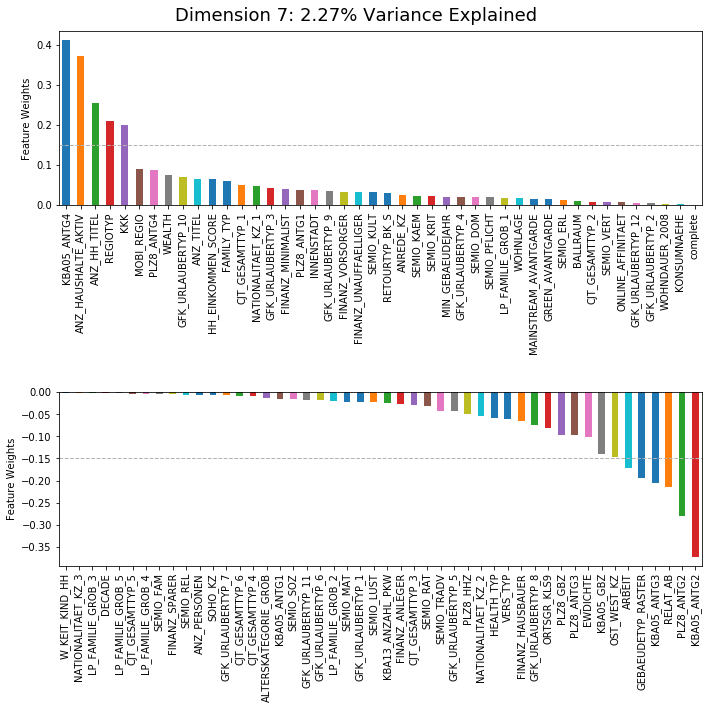

In [109]:
# Looking at the seventh dimension
plot_pca_dim(results, pca_20, 'Dimension 7', figsize=(10, 10))

In [110]:
weighted_features(results, 'Dimension 7')

High Positive
 KBA05_ANTG4            0.4135
ANZ_HAUSHALTE_AKTIV    0.3718
ANZ_HH_TITEL           0.2546
REGIOTYP               0.2091
KKK                    0.1997
Name: Dimension 7, dtype: float64

High Negative
 KBA05_ANTG2          -0.3742
PLZ8_ANTG2           -0.2796
RELAT_AB             -0.2148
KBA05_ANTG3          -0.2063
GEBAEUDETYP_RASTER   -0.1943
ARBEIT               -0.1719
Name: Dimension 7, dtype: float64


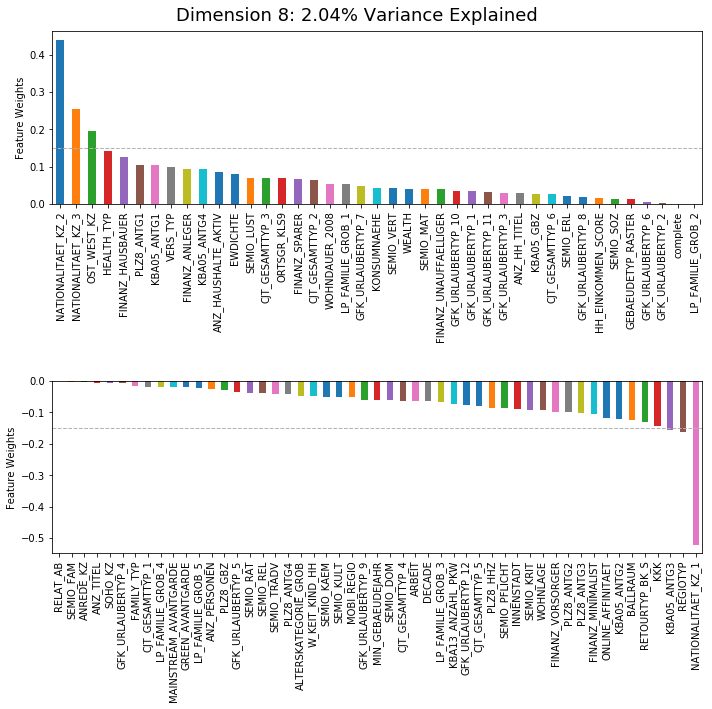

In [111]:
# Looking at the eigth dimension
plot_pca_dim(results, pca_20, 'Dimension 8', figsize=(10, 10))

In [112]:
weighted_features(results, 'Dimension 8')

High Positive
 NATIONALITAET_KZ_2    0.4397
NATIONALITAET_KZ_3    0.2547
OST_WEST_KZ           0.1945
Name: Dimension 8, dtype: float64

High Negative
 NATIONALITAET_KZ_1   -0.5220
REGIOTYP             -0.1616
KBA05_ANTG3          -0.1557
Name: Dimension 8, dtype: float64


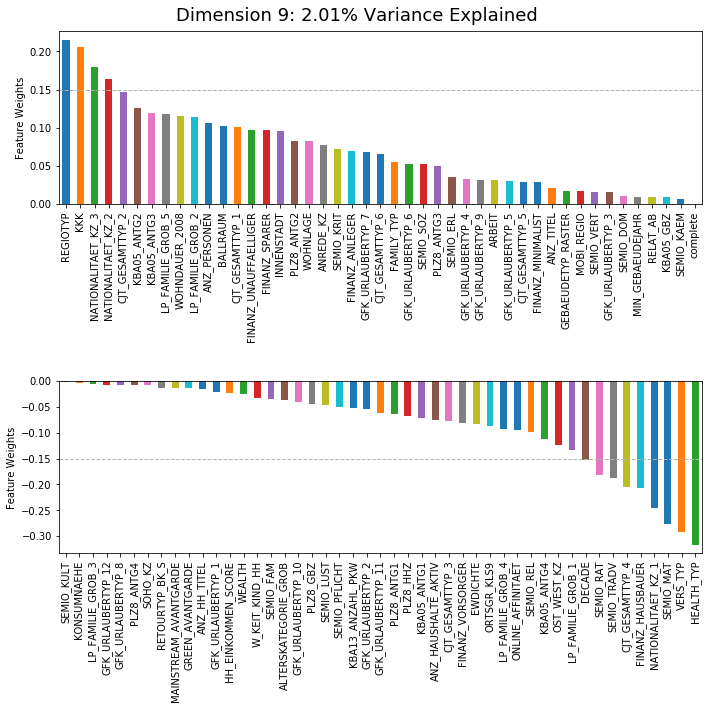

In [113]:
# Looking at the ninth dimension
plot_pca_dim(results, pca_20, 'Dimension 9', figsize=(10, 10))

In [114]:
weighted_features(results, 'Dimension 9')

High Positive
 REGIOTYP              0.2152
KKK                   0.2058
NATIONALITAET_KZ_3    0.1791
NATIONALITAET_KZ_2    0.1640
Name: Dimension 9, dtype: float64

High Negative
 HEALTH_TYP           -0.3173
VERS_TYP             -0.2916
SEMIO_MAT            -0.2766
NATIONALITAET_KZ_1   -0.2450
FINANZ_HAUSBAUER     -0.2077
CJT_GESAMTTYP_4      -0.2047
SEMIO_TRADV          -0.1874
SEMIO_RAT            -0.1817
DECADE               -0.1527
Name: Dimension 9, dtype: float64


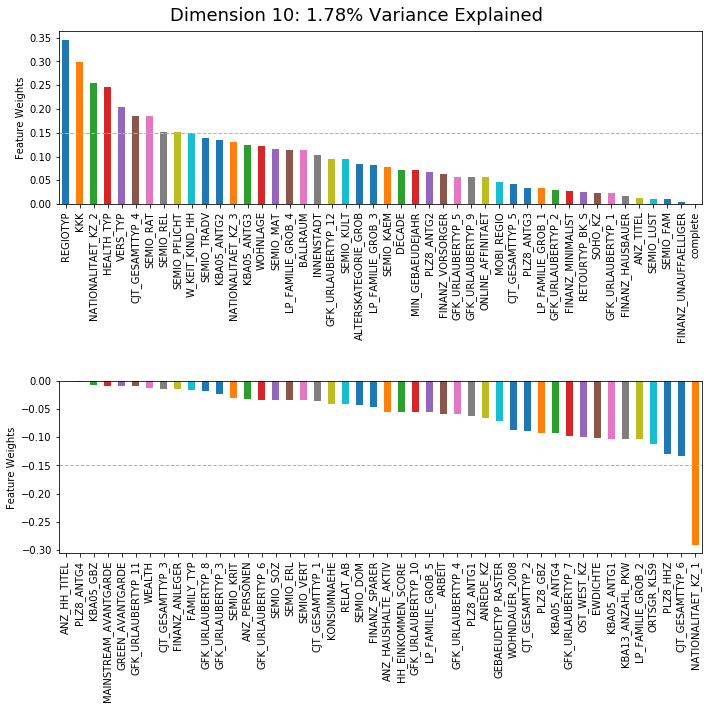

In [115]:
# Looking at the ninth dimension
plot_pca_dim(results, pca_20, 'Dimension 10', figsize=(10, 10))

In [116]:
weighted_features(results, 'Dimension 10')

High Positive
 REGIOTYP              0.3456
KKK                   0.2990
NATIONALITAET_KZ_2    0.2539
HEALTH_TYP            0.2458
VERS_TYP              0.2050
CJT_GESAMTTYP_4       0.1849
SEMIO_RAT             0.1848
SEMIO_REL             0.1517
SEMIO_PFLICHT         0.1509
Name: Dimension 10, dtype: float64

High Negative
 NATIONALITAET_KZ_1   -0.2913
Name: Dimension 10, dtype: float64


### Discussion 2.3: Interpret Principal Components

Based on the loaded feature weights, the first ten dimensions map quite well onto defined potential customer segments:

Here are the details of the segment most aligned with missing data (Dimension 4, 4.12% Variance Explained):

High positive:
NATIONALITAET_KZ_0 (Nationality based on given name analysis: Unknown)
MAINSTREAM_AVANTGARDE (Social participation/influence: High +ve more likely avantgarde)
LP_FAMILIE_GROB_0 (Family type: Unknown)
HH_EINKOMMEN_SCORE (Estimated household net income)
GFK_URLAUBERTYP (Vacation habits: Nature fans)
CJT_GESAMTTYP_6 (Customer-Journey-Typology: Advertising-Enthusiast with restricted Cross-Channel-Behaviour)
High negative

complete (More likely to have missing data)
NATIONALITAET_KZ_1 (Nationality based on given name analysis: German-sounding)
SEMIO_FAM (Family-minded)
ANREDE_KZ (Gender: high -ve more likely male)
SEMIO_REL (Religious)
SEMIO_LUST (Sensual-minded)
As can be seen, a other features that represent missing data also load on to this dimension. It seems as if people who are more likely to have missing data are less likely to be 'long-term' German, more likely to be male, more likely to be avantgarde, and more likely to be wealthy.

We compare those details with the segmost most aligned with complete data (Dimension 5, 3.45% Variance Explained):

High positive:
GREEN_AVANTGARDE (Membership in environmental sustainability as part of youth)
ANZ_PERSONEN (Number of adults in household)
EWDICHTE (Density of households per square kilometer)
ONLINE_AFFINITAET (Online affinity)
ORTSGR_KLS9 (Size of community)
W_KEIT_KIND_HH (Likelihood of children in household)
LP_FAMILIE_GROB_5 (Family type: Multiperson household, sharing and multi-generational)
KKK (Purchasing power in region)
MAINSTREAM_AVANTGARDE (Social participation/ifluence: High +ve more likely avantgarde)
complete (More likely to have complete data)
REGIOTYP (Neighborhood typology: High +ve more likely affluent)
High negative:
BALLRAUM (Distance to nearest urban center)
KKK (Purchasing power in region)
INNENSTADT (Distance to city center (downtown))
LP_FAMILIE_GROB_1 (Family type: Single)
These people are also more likely to be avantgarde (so this is not necessarily a distinguishing feature), more likely to be affluent, in larger families, and living in cities.

It does appear as if there might be a group of wealthy, "not long-term German", men that have been missed by dropping the missing values. This may be beneficial for exploration in the future. However, if marketing is targeted to some of the other segments that have been identified (e.g. savvy male investors, wealthy "immigrant" families, wealthy professionals), these might be captured anyway.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [117]:
kmeans_10 = KMeans(n_clusters=10).fit(X_pca_20)

In [118]:
kmeans_10.score(X_pca_20)

-20126946.543863568

In [119]:
# Investigating the best clustering value
k_means = range(5, 31)
scores = []

for k in k_means:
    print('Starting k = {} fitting'.format(k))
    model = KMeans(k).fit(X_pca_20)
    score = model.score(X_pca_20)
    scores.append(-score)

Starting k = 5 fitting
Starting k = 6 fitting
Starting k = 7 fitting
Starting k = 8 fitting
Starting k = 9 fitting
Starting k = 10 fitting
Starting k = 11 fitting
Starting k = 12 fitting
Starting k = 13 fitting
Starting k = 14 fitting
Starting k = 15 fitting
Starting k = 16 fitting
Starting k = 17 fitting
Starting k = 18 fitting
Starting k = 19 fitting
Starting k = 20 fitting
Starting k = 21 fitting
Starting k = 22 fitting
Starting k = 23 fitting
Starting k = 24 fitting
Starting k = 25 fitting
Starting k = 26 fitting
Starting k = 27 fitting
Starting k = 28 fitting
Starting k = 29 fitting
Starting k = 30 fitting


In [120]:
k_means = range(1, 5)
low_scores = []

for k in k_means:
    print('Starting k = {} fitting'.format(k))
    model = KMeans(k).fit(X_pca_20)
    score = model.score(X_pca_20)
    low_scores.append(-score)

Starting k = 1 fitting
Starting k = 2 fitting
Starting k = 3 fitting
Starting k = 4 fitting


In [121]:
total_scores = low_scores + scores

Text(0,0.5,'SSE')

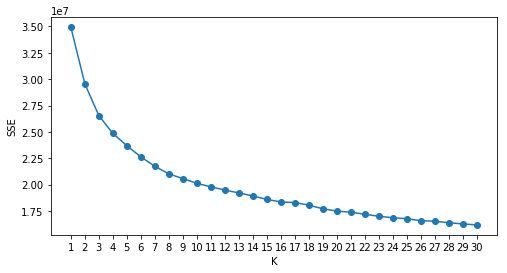

In [122]:
# Plot elbow plot
x = range(1, 31)
plt.figure(figsize=(8, 4))
plt.plot(x, total_scores, marker='o')
plt.xticks(x)
plt.xlabel('K')
plt.ylabel('SSE')

In [123]:
# Fitting with K=8
kmeans_8 = KMeans(n_clusters=8).fit(X_pca_20)

### Discussion 3.1: Apply Clustering to General Population

The curve for the clustering didn't have a sharp obvious change. The change from 7 to 8 seemed to be associated with a change to flattening, so I decided to use 8 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [124]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.shape

(191652, 85)

In [125]:
# Clean data
customers_clean = customers.copy()
customers_clean = clean_data(customers_clean)

In [126]:
# Check that shape matches
customers_clean.shape

(115643, 92)

In [127]:
# Change in missing rows
customer_missing = 191652 - 115643
customer_missing

76009

In [128]:
# Impute means
customers_imputed = imputer.transform(customers_clean)
# Standardize
customers_standard = scaler.transform(customers_imputed)
# Clustered 
customers_pca = pca_20.transform(customers_standard)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [129]:
# Predict labels for data
azdias_predict = pd.DataFrame(np.array(kmeans_8.predict(X_pca_20)), columns=['Predictions'])
customer_predict = pd.DataFrame(np.array(kmeans_8.predict(customers_pca)), columns=['Predictions'])

In [130]:
# Create value counts
azdias_prop = azdias_predict.groupby('Predictions').size()
customer_prop = customer_predict.groupby('Predictions').size()
print(azdias_prop)
print(customer_prop)

Predictions
0    101382
1     57745
2     87374
3    100462
4     58099
5     63414
6     64270
7     90463
dtype: int64
Predictions
0    59462
1     4390
2    13084
3    23304
4     1312
5     1155
6     2332
7    10604
dtype: int64


In [131]:
# Calculate missing proportions
azdias_miss_prop = pd.Series(azdias.shape[0] - azdias_consistent_code.shape[0])
customer_miss_prop = pd.Series(customers.shape[0] - customers_clean.shape[0])
# Append on to arrays
azdias_prop = azdias_prop.append(azdias_miss_prop)
customer_prop = customer_prop.append(customer_miss_prop)
print(azdias_prop)
print(customer_prop)

0    101382
1     57745
2     87374
3    100462
4     58099
5     63414
6     64270
7     90463
0    268012
dtype: int64
0    59462
1     4390
2    13084
3    23304
4     1312
5     1155
6     2332
7    10604
0    76009
dtype: int64


In [132]:
azdias_prop.index = range(9)
customer_prop.index = range(9)

In [133]:
azdias_prop = (azdias_prop/azdias_prop.sum()).reset_index()
customer_prop = (customer_prop/customer_prop.sum()).reset_index()

In [134]:
azdias_prop['source'] = 'population'
azdias_prop.columns = ['label', 'proportion', 'source']
customer_prop['source'] = 'customers'
customer_prop.columns = ['label', 'proportion', 'source']

In [136]:
predictions = pd.concat([azdias_prop, customer_prop])
#predictions.columns = ['population', 'customer']
predictions.head()

,label,proportion,source
0,0,0.113756,population
1,1,0.064793,population
2,2,0.098039,population
3,3,0.112724,population
4,4,0.065190,population


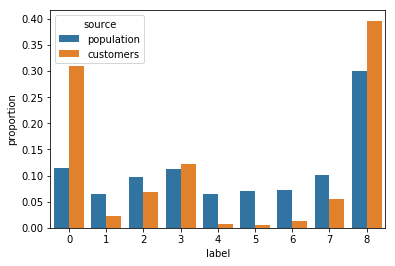

In [137]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
sns.barplot(x='label', y='proportion', hue='source', data=predictions)

In [138]:
# Join customer pca details with predictions
customer_labels = pd.merge(left=pd.DataFrame(customers_pca), right=customer_predict, left_index=True, right_index=True)
customer_labels.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,Predictions
0,-5.647994,-0.790154,4.208341,3.245949,-4.372212,1.114466,0.940816,1.505062,1.891467,2.398144,...,-1.878918,3.111949,-2.033391,-0.823135,-0.187243,-0.484073,-2.009679,0.111817,-1.122730,0
1,-2.273419,3.422363,-1.228836,2.950813,-0.619679,-1.291177,-0.712249,3.019020,1.105405,1.368029,...,-3.006327,1.493464,-0.257671,-0.200934,-0.293395,-0.930035,-0.581579,1.758390,-2.399933,3
2,1.446602,-1.527351,1.104600,0.682379,2.169000,1.870491,-1.998992,0.646123,-0.072043,1.893929,...,-2.635685,-0.023655,0.730156,0.323181,1.069476,0.651997,1.786480,0.177648,0.037922,2
3,-2.301522,0.129171,2.608830,3.116291,-3.358242,1.302737,-1.059828,2.230649,0.559224,2.302368,...,0.841807,2.503076,-0.160108,1.703541,0.326740,-1.177400,-0.353758,0.598890,-2.040201,0
4,-5.272066,-1.150821,2.678534,1.697727,-2.694860,1.225116,0.782603,2.167284,1.746400,1.214614,...,-1.866308,2.425052,-0.911026,0.957051,-1.299441,-0.069311,-1.231127,1.149105,-3.631665,0


In [139]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
over_transform = pca_20.inverse_transform(customer_labels.query('Predictions == 1').drop('Predictions', axis=1))
over_regular = scaler.inverse_transform(over_transform)

In [140]:
# Convert to df
over_df = pd.DataFrame(over_regular, columns=customers_clean.columns)

In [141]:
over_df.mean()[:35]

ALTERSKATEGORIE_GROB        2.389333
ANREDE_KZ                   1.016564
FINANZ_MINIMALIST           1.055391
FINANZ_SPARER               1.441237
FINANZ_VORSORGER            2.505008
FINANZ_ANLEGER              1.992111
FINANZ_UNAUFFAELLIGER       1.061877
FINANZ_HAUSBAUER            3.433077
GREEN_AVANTGARDE            1.005560
HEALTH_TYP                  2.054330
DECADE                   1984.473031
RETOURTYP_BK_S              2.570818
SEMIO_SOZ                   1.103080
SEMIO_FAM                   1.387596
SEMIO_REL                   2.041180
SEMIO_MAT                   3.223507
SEMIO_VERT                  0.777645
SEMIO_LUST                  2.741402
SEMIO_ERL                   4.170630
SEMIO_KULT                  1.297554
SEMIO_RAT                   3.762058
SEMIO_KRIT                  4.291732
SEMIO_DOM                   4.057431
SEMIO_KAEM                  4.912675
SEMIO_PFLICHT               2.640295
SEMIO_TRADV                 2.895075
SOHO_KZ                     0.014007
V

In [142]:
over_df.mean()[35:]

KONSUMNAEHE                 2.939086
MIN_GEBAEUDEJAHR         1993.259498
OST_WEST_KZ                 0.905308
WOHNLAGE                    2.228413
KBA05_ANTG1                 3.079256
KBA05_ANTG2                 1.063182
KBA05_ANTG3                -0.066870
KBA05_ANTG4                -0.141522
KBA05_GBZ                   4.549998
BALLRAUM                    3.960200
EWDICHTE                    3.921490
INNENSTADT                  4.565529
GEBAEUDETYP_RASTER          3.672044
KKK                         2.119737
MOBI_REGIO                  1.508669
ONLINE_AFFINITAET           4.579463
REGIOTYP                    4.039726
KBA13_ANZAHL_PKW          712.624715
PLZ8_ANTG1                  2.625243
PLZ8_ANTG2                  2.694281
PLZ8_ANTG3                  1.314451
PLZ8_ANTG4                  0.481173
PLZ8_HHZ                    3.827603
PLZ8_GBZ                    3.895726
ARBEIT                      2.837683
ORTSGR_KLS9                 5.261096
RELAT_AB                    2.816190
C

In [143]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
under_transform = pca_20.inverse_transform(customer_labels.query('Predictions == 0').drop('Predictions', axis=1))
under_regular = scaler.inverse_transform(under_transform)
under_df = pd.DataFrame(under_regular, columns=customers_clean.columns)

In [144]:
under_df.mean()[:35]

ALTERSKATEGORIE_GROB        3.567824
ANREDE_KZ                   1.068230
FINANZ_MINIMALIST           0.043188
FINANZ_SPARER               3.309298
FINANZ_VORSORGER            0.854650
FINANZ_ANLEGER              3.583285
FINANZ_UNAUFFAELLIGER       2.464935
FINANZ_HAUSBAUER            3.090413
GREEN_AVANTGARDE            1.124123
HEALTH_TYP                  1.505464
DECADE                   1965.012614
RETOURTYP_BK_S              1.489852
SEMIO_SOZ                   1.710199
SEMIO_FAM                   2.453263
SEMIO_REL                   3.758307
SEMIO_MAT                   4.078045
SEMIO_VERT                  0.672648
SEMIO_LUST                  0.743787
SEMIO_ERL                   2.745016
SEMIO_KULT                  2.655036
SEMIO_RAT                   5.045121
SEMIO_KRIT                  3.984519
SEMIO_DOM                   4.301313
SEMIO_KAEM                  4.786528
SEMIO_PFLICHT               4.579219
SEMIO_TRADV                 4.456058
SOHO_KZ                     0.013905
V

In [145]:
under_df.mean()[35:]

KONSUMNAEHE                 3.029187
MIN_GEBAEUDEJAHR         1993.197961
OST_WEST_KZ                 0.911521
WOHNLAGE                    2.345812
KBA05_ANTG1                 3.360328
KBA05_ANTG2                 0.945175
KBA05_ANTG3                -0.253760
KBA05_ANTG4                -0.151754
KBA05_GBZ                   4.720227
BALLRAUM                    3.611095
EWDICHTE                    4.065883
INNENSTADT                  4.358274
GEBAEUDETYP_RASTER          3.744167
KKK                         2.193271
MOBI_REGIO                  1.272474
ONLINE_AFFINITAET           3.423642
REGIOTYP                    4.013792
KBA13_ANZAHL_PKW          716.186730
PLZ8_ANTG1                  2.741975
PLZ8_ANTG2                  2.604598
PLZ8_ANTG3                  1.208622
PLZ8_ANTG4                  0.413342
PLZ8_HHZ                    3.832646
PLZ8_GBZ                    3.981690
ARBEIT                      2.916189
ORTSGR_KLS9                 5.490229
RELAT_AB                    2.887832
C

### Discussion 3.3: Compare Customer Data to Demographics Data

One of the segments that is unpopular with the mailing company appears to be City Youth. While they were not specifically aligned with an online affinity, it does seem like they would be less interested in mail order type sales.

An over represented segment for the company is older, traditional people. As mail order sales company does seem a more attractive purchasing option for them.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.